In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from google.colab import drive
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import datasets
import evaluate
import accelerate
import timm
from huggingface_hub import notebook_login
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             confusion_matrix, ConfusionMatrixDisplay, classification_report,
                             average_precision_score)
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import re

In [3]:
from transformers import logging
# mute transformers output warnings (e.g. weights not used, tokenizer with lower case vocab, etc.)
logging.set_verbosity_error()
# reset default to show all output warnings
# logging.set_verbosity_debug()

In [3]:
#login into hugging face to access model
# notebook_login()

In [4]:
# Load data file & check
data_prime = pd.read_csv("full_cleaned_data.csv")
print(data_prime.head())

   job_id                                      title            location  \
0       1                           Marketing Intern    US, NY, New York   
1       2  Customer Service - Cloud Video Production      NZ, , Auckland   
2       3    Commissioning Machinery Assistant (CMA)       US, IA, Wever   
3       4          Account Executive - Washington DC  US, DC, Washington   
4       5                        Bill Review Manager  US, FL, Fort Worth   

  department salary_range                                    company_profile  \
0  Marketing          NaN  We're Food52, and we've created a groundbreaki...   
1    Success          NaN  90 Seconds, the worlds Cloud Video Production ...   
2        NaN          NaN  Valor Services provides Workforce Solutions th...   
3      Sales          NaN  Our passion for improving quality of life thro...   
4        NaN          NaN  SpotSource Solutions LLC is a Global Human Cap...   

                                         description  \
0  Foo

In [5]:
# check if using GPU
if torch.cuda.is_available():
  print(True, torch.cuda.get_device_name(0))
else:
  print(False, "GPU not connected")

True NVIDIA GeForce RTX 4060 Laptop GPU


In [6]:
torch.cuda.device_count()

1

In [7]:
# set seed for reproducibility in all packages
Seed = 42
np.random.seed(Seed)
torch.manual_seed(Seed)

# set GPU seed too
torch.cuda.manual_seed_all(Seed)

**Exploratory Data Analysis**


---



*   Check column names
*   Check dataframe shape
* Check missing values
* Check duplicate columns
* Compare text length of fradulent vs real job classification  




In [8]:
# make deep copy to prevent messing original
data = data_prime.copy(deep = True)

In [9]:
# Check column names
print(data.columns)

Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent', 'description_length', 'req_len', 'null_count',
       'description_clean', 'vector_word2vec'],
      dtype='object')


In [10]:
# Check dataframe shape
print(data.shape)

(17837, 23)


In [11]:
# Check missing values in each column in percentage
missing = data.isna().mean().mul(100).sort_values(ascending=False).round(2)
missing_df = missing.rename("missing_percent").reset_index().rename(columns={"index": "column"})
print("\n Missingness (% by column):")
print(missing_df)


 Missingness (% by column):
                 column  missing_percent
0          salary_range            83.95
1            department            64.53
2    required_education            45.25
3              benefits            40.23
4   required_experience            39.39
5              function            36.05
6              industry            27.37
7       employment_type            19.35
8       company_profile            18.42
9          requirements            14.95
10             location             1.93
11    description_clean             0.01
12          description             0.00
13               job_id             0.00
14                title             0.00
15        has_questions             0.00
16     has_company_logo             0.00
17        telecommuting             0.00
18           fraudulent             0.00
19   description_length             0.00
20              req_len             0.00
21           null_count             0.00
22      vector_word2vec     

**Pre-processing** : Dropping columns


---


Given high missing values (> 50%) in salary_range and department. We can drop these columns, as it would provide no useful information, and imputation would cause bias.

In [12]:
# drop columns with missing values accounting more than 50%
data.drop(['salary_range', 'department'], axis=1, inplace=True)

# dropping job_id column cause seems of no use
data.drop(['job_id'], axis=1, inplace=True)

In [13]:
# check missingness in description
print(f"Number of missing description = {data['description'].isnull().sum()}")

# as only 1 row is missing, probably not correlated information for fraudulent job posting
# drop missing row, as we will be using the column for description mostly for this analysis
data.dropna(subset=['description'], inplace=True)

# sanity check for missingness in description
print(f"Post drop number of missing description = {data['description'].isnull().sum()}")

Number of missing description = 0
Post drop number of missing description = 0


**Feature engineering **


---



1.   Would longer/ shorter description be related to fraudulent job positing?
2.   Convert required_education, benefits, required_experience to binary indicator, for perhaps there is a connection
3. Would null informations in each job posting be related to fraudulent job posting?






In [14]:
# Would longer / shorter description be related to fraudulent data?
data["desc_len"] = data["description"].fillna("").str.split().map(len)

In [15]:
# Convert required_education, benefits, required_experience, logo, requirement to binary indicator, for perhaps there is a connection
# to do later? cause albert can only process text?? (need to do some layering NN? for numerical + text)
for col in ["required_education", "benefits", "required_experience", "has_company_logo", "requirements"]:
    if col in data.columns:
        data[f"binary_{col}"] = (~data[col].isna()).astype(int)

In [16]:
# Would null informations in each job posting be related to fraudulent job posting?
data["null_count"] = data.isnull().sum(axis=1)

**Text cleaning**


---

Prior to check for duplicate rows of job postings. We will first remove the URL links.

Then we will normalize (lower case) the columns with text data -- title, company_profile, description, requirements, and benefits.

In [17]:
# Select text columns to normalize for EDA/dedupe
TEXT_COLS = ["title", "location", "company_profile", "description", "requirements", "benefits"]
TEXT_COLS = [c for c in TEXT_COLS if c in data.columns]

# ---- Regex patterns----
# All the url patterns noted
PAT_TOKEN_EMBEDDED_URL = re.compile(r"(?:https?://|www\.)\S*#url_[^#\s]+#\S*", flags=re.IGNORECASE)
PAT_URL_TOKEN   = re.compile(r"#url_[^#\s]+#?",   flags=re.IGNORECASE)
PAT_EMAIL_TOKEN = re.compile(r"#email_[^#\s]+#?", flags=re.IGNORECASE)
PAT_HTTP_URL = re.compile(r"\bhttps?://\S+|\bwww\.\S+", flags=re.IGNORECASE)

# Simple HTML tags and leftover separators
PAT_HTML     = re.compile(r"<[^>]+>")
PAT_BAR_SPAM = re.compile(r"(\s*[\|\-–—•]+\s*)+")

def clean_urls_and_html(text: str) -> str:
    if pd.isna(text):
        return ""
    s = str(text).lower()
    s = PAT_HTML.sub(" ", s)                   # 1) strip html tags
    s = PAT_TOKEN_EMBEDDED_URL.sub(" ", s)     # 2) remove token-embedded URLs
    s = PAT_URL_TOKEN.sub(" ", s)              # 3) remove standalone #URL_...#
    s = PAT_EMAIL_TOKEN.sub(" ", s)            #    remove standalone #EMAIL_...#
    s = PAT_HTTP_URL.sub(" ", s)               # 4) remove any remaining http/https/www urls
    s = PAT_BAR_SPAM.sub(" ", s)               # 5) collapse leftover separators
    s = re.sub(r"\s+", " ", s).strip()         # 6) collapse spaces
    return s

# remove email and url links (normalize)
data_norm = data.copy(deep = True)
for col in TEXT_COLS:
    data_norm[col + "_norm"] = data_norm[col].map(clean_urls_and_html)

print(f"Normalized columns created: {[c+'_norm' for c in TEXT_COLS]}")

# check if urls/ email links are gone
check_cols = [c for c in ["description_norm","requirements_norm"] if c in data_norm.columns]
for col in check_cols:
    leftovers = data_norm[col].str.contains(r"#url_|#email_|https?://|www\.", case=False, na=False).sum()
    print(f"{col}: URL/ EMAIL leftover = {leftovers}")

# Print any url/ email leftover
for col in check_cols:
    mask = data_norm[col].str.contains(r"#url_|#email_|https?://|www\.", case=False, na=False)
    if mask.any():
        print(f"\n--- Leftover rows in {col} ---")
        display(
            data_norm.loc[mask, [
                *[c for c in ["title","location","company_profile","requirements","description"] if c in data_norm.columns],
                col
            ]].head(50)  # show up to 50
        )

Normalized columns created: ['title_norm', 'location_norm', 'company_profile_norm', 'description_norm', 'requirements_norm', 'benefits_norm']
description_norm: URL/ EMAIL leftover = 0
requirements_norm: URL/ EMAIL leftover = 0


In [18]:
# Check for duplicate job postings
# Define which normalized fields must match to consider "same posting"
# NORM_KEYS = [c for c in [
#     "title_norm", "company_profile_norm", "description_norm", "requirements_norm", "benefits_norm"
# ] if c in data_norm.columns]

# location has 1% missingness. Filling with "unavailable"
data_norm["location_norm"] = data_norm["location_norm"].fillna("unavailable")

# removed benefits and company_profile cause tons of missing values
NORM_KEYS = [c for c in [
    "title_norm", "location_norm", "description_norm"
] if c in data_norm.columns]

# Mark all members of duplicate groups (keep=False)
row_dupe_mask = data_norm.duplicated(subset=NORM_KEYS, keep=False)
num_row_dupes = int(row_dupe_mask.sum())
print(f"[Row duplicates by normalized text] rows flagged = {num_row_dupes}")

# Compact group summary: how many records per duplicate group
row_dupe_groups = (
    data_norm.loc[row_dupe_mask]
             .groupby(NORM_KEYS, dropna=False)
             .size()
             .reset_index(name="count")
             .sort_values("count", ascending=False)
)
print(f"[Row duplicate groups] groups = {row_dupe_groups.shape[0]}")
display(row_dupe_groups.head(10))

# # Peek at example duplicate rows
# cols_to_show = [k.replace("_norm","") for k in NORM_KEYS] + NORM_KEYS + \
#                (["fraudulent"] if "fraudulent" in data_norm.columns else [])
# if num_row_dupes > 0:
#     print("\n[Sample duplicate rows]")
#     display(data_norm.loc[row_dupe_mask, cols_to_show].head(10))

[Row duplicates by normalized text] rows flagged = 1112
[Row duplicate groups] groups = 489


,title_norm,location_norm,description_norm,count
126,customer service associate,"us, ny, new york",the customer service associate will be based i...,11
87,contact center representatives,"us, nv, las vegas","tidewater finance company, located in henderso...",9
292,linux system administrator,"ca, on, toronto",unotelly is a dns &amp; vpn service that allow...,7
55,call center supervisor,"us, va, virginia beach","tidewater finance company, located in virginia...",6
457,title insurance ops: sr title officer/counsel,"us, ny, woodbury",a well established title insurance agency base...,6
142,customer service associate part time,"us, ny, new york",the customer service associate will be based i...,6
319,mirfield warehousing apprenticeship under nas ...,"gb, , mirfield",government funding is only available for 16 18...,6
141,customer service associate part time,"us, ny, new york",the customer service associate will be based i...,5
78,collections supervisor,"us, nv, las vegas",west coast service center collections supervis...,5
298,maintenance mechanic,"us, ny, niagara falls",department: maintenancereports to: maintenance...,5


In [19]:
# remove the duplicates
data_dup_drop = data_norm.drop_duplicates(subset=NORM_KEYS, keep="first")

print(f"Original rows: {data_norm.shape[0]}")
print(f"After dropping duplicates: {data_dup_drop.shape[0]}")
print(f"Rows removed as duplicates: {data_norm.shape[0] - data_dup_drop.shape[0]}")

# Sanity check: are we losing fraudulent examples disproportionately?
fraud_rate_before = data_norm["fraudulent"].mean() * 100
fraud_rate_after  = data_dup_drop["fraudulent"].mean() * 100

print(f"Fraud rate before dropping duplicates: {fraud_rate_before:.2f}%")
print(f"Fraud rate after  dropping duplicates: {fraud_rate_after:.2f}%")

# Sanity check: no duplicates remain
remaining_dupes = data_dup_drop.duplicated(subset=NORM_KEYS, keep=False).sum()
print(f"Remaining duplicate rows (should be 0): {remaining_dupes}")


Original rows: 17837
After dropping duplicates: 17214
Rows removed as duplicates: 623
Fraud rate before dropping duplicates: 4.84%
Fraud rate after  dropping duplicates: 4.72%
Remaining duplicate rows (should be 0): 0



[Class balance]
 fraudulent  count  percent
          0  16401    95.28
          1    813     4.72


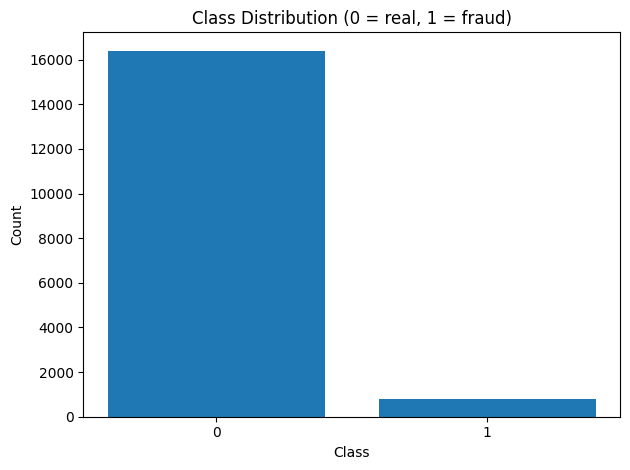

In [20]:
# Check for class balance
cls_df = (data_dup_drop["fraudulent"]
          .value_counts(dropna=False)
          .rename_axis("fraudulent")
          .reset_index(name="count")
          .sort_values("fraudulent"))
cls_df["percent"] = (cls_df["count"] / cls_df["count"].sum() * 100).round(2)

print("\n[Class balance]")
print(cls_df.to_string(index=False))

# Bar chart
plt.figure()
plt.bar(cls_df["fraudulent"].astype(str), cls_df["count"].values)
plt.title("Class Distribution (0 = real, 1 = fraud)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

Long-tailed class imbalance observed. Counter measures must be considered.

**Splitting data for cross-validation**

---

Given long tail imbalance

In [21]:
# renaming the data_dup_drop to data_use, so i remember better
data_use = data_dup_drop.copy(deep = True)

In [22]:
print(data_use.columns)
print("==")
print(data.columns)

Index(['title', 'location', 'company_profile', 'description', 'requirements',
       'benefits', 'telecommuting', 'has_company_logo', 'has_questions',
       'employment_type', 'required_experience', 'required_education',
       'industry', 'function', 'fraudulent', 'description_length', 'req_len',
       'null_count', 'description_clean', 'vector_word2vec', 'desc_len',
       'binary_required_education', 'binary_benefits',
       'binary_required_experience', 'binary_has_company_logo',
       'binary_requirements', 'title_norm', 'location_norm',
       'company_profile_norm', 'description_norm', 'requirements_norm',
       'benefits_norm'],
      dtype='object')
==
Index(['title', 'location', 'company_profile', 'description', 'requirements',
       'benefits', 'telecommuting', 'has_company_logo', 'has_questions',
       'employment_type', 'required_experience', 'required_education',
       'industry', 'function', 'fraudulent', 'description_length', 'req_len',
       'null_count', 'des

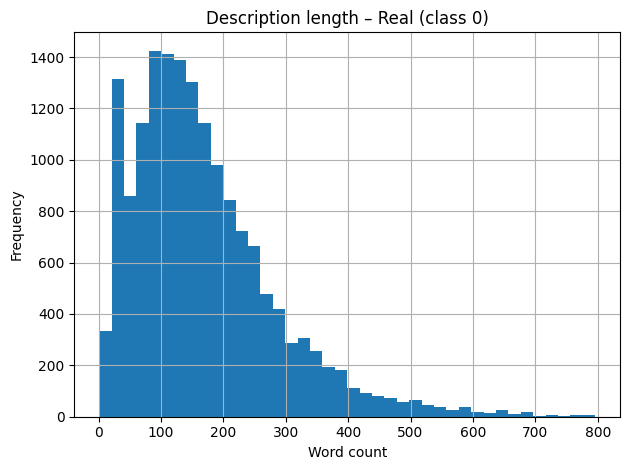

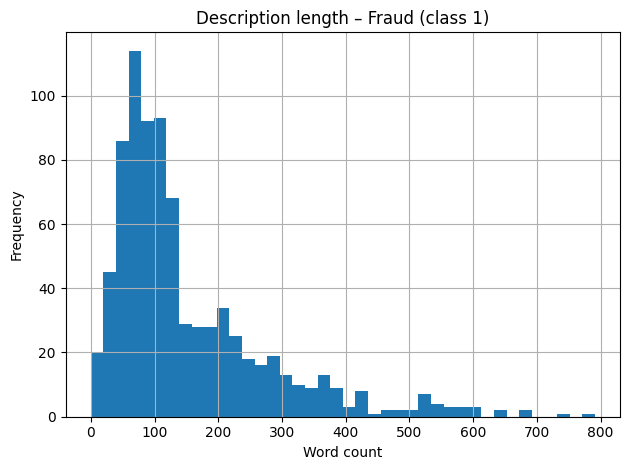

C:\Users\Axioo Pongo\AppData\Local\Temp\ipykernel_14012\3269020504.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=["Real (0)", "Fraud (1)"], showfliers=False)


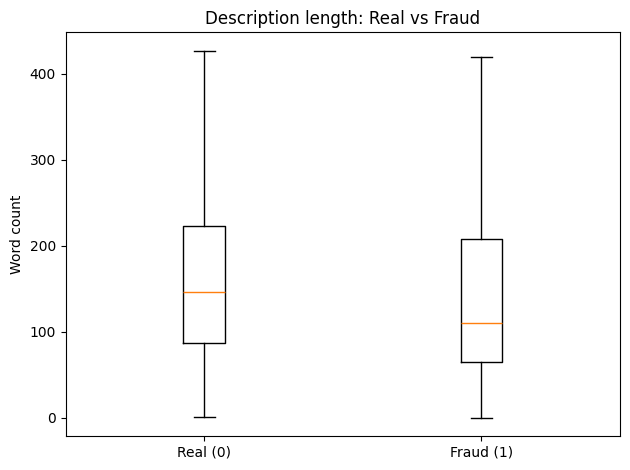

In [23]:
# Compare text length of fradulent vs real job classification

# Hist: description length per class
plt.figure()
data_use.loc[data_use["fraudulent"]==0, "desc_len"].hist(bins=40)
plt.title("Description length – Real (class 0)")
plt.xlabel("Word count"); plt.ylabel("Frequency"); plt.tight_layout(); plt.show()

plt.figure()
data_use.loc[data_use["fraudulent"]==1, "desc_len"].hist(bins=40)
plt.title("Description length – Fraud (class 1)")
plt.xlabel("Word count"); plt.ylabel("Frequency"); plt.tight_layout(); plt.show()

# Boxplot side-by-side
plt.figure()
data_to_plot = [
    data_use.loc[data_use["fraudulent"]==0, "desc_len"].dropna(),
    data_use.loc[data_use["fraudulent"]==1, "desc_len"].dropna()
]
plt.boxplot(data_to_plot, labels=["Real (0)", "Fraud (1)"], showfliers=False)
plt.title("Description length: Real vs Fraud"); plt.ylabel("Word count")
plt.tight_layout(); plt.show()


Boxplot for description length is not so different between real and fraudulent job postings. It may not be a good classification tool. Will try with and without to compare.

**ALBERT**


---

Using description only to model.

In [24]:
# ==== ALBERT (desc-only) with Focal Loss + threshold tuning (fast, no eval strategy) ====
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from transformers import (AutoTokenizer, AlbertForSequenceClassification,
                          TrainingArguments, Trainer, DataCollatorWithPadding)

In [25]:
# ----------------------------
# 0) Data (expects data_use with 'description' and 'fraudulent' {0,1})
# ----------------------------
data_model = data_use[data_use["description"].notna()].copy()

# Train/Test (80/20), then carve 10% (approx) of full data as Validation from Train
train_df, test_df = train_test_split(
    data_model, test_size=0.20, stratify=data_model["fraudulent"], random_state=42
)
base_train_df, val_df = train_test_split(
    train_df, test_size=0.125, stratify=train_df["fraudulent"], random_state=42
)  # 0.125 of 80% ≈ 10% total as validation

In [26]:
# ----------------------------
# 1) Tokenizer + tokenization (shorter seq for speed; dynamic padding later)
# ----------------------------
tokenizer = AutoTokenizer.from_pretrained("albert-base-v2")

def tok(series, max_len=325):
    return tokenizer(series.tolist(), truncation=True, max_length=max_len)

train_enc = tok(base_train_df["description"], 325)
val_enc   = tok(val_df["description"], 325)
test_enc  = tok(test_df["description"], 325)

y_train = base_train_df["fraudulent"].values.astype(int)
y_val   = val_df["fraudulent"].values.astype(int)
y_test  = test_df["fraudulent"].values.astype(int)

In [27]:
# ----------------------------
# 2) Datasets (lists -> collator pads & tensorizes on the fly)
# ----------------------------
class TextDS(torch.utils.data.Dataset):
    def __init__(self, enc, labels):
        self.enc, self.labels = enc, labels
    def __len__(self): return len(self.labels)
    def __getitem__(self, i):
        return {
            "input_ids": self.enc["input_ids"][i],
            "attention_mask": self.enc["attention_mask"][i],
            "labels": int(self.labels[i]),
        }

train_ds = TextDS(train_enc, y_train)
val_ds   = TextDS(val_enc, y_val)
test_ds  = TextDS(test_enc, y_test)

data_collator = DataCollatorWithPadding(tokenizer, pad_to_multiple_of=8)

In [28]:
# ----------------------------
# 3) Class weights FROM TRAIN ONLY (no leakage)
# ----------------------------
counts = base_train_df["fraudulent"].value_counts().sort_index()  # index: 0,1
total  = counts.sum()
class_weights = torch.tensor([total/counts[0], total/counts[1]], dtype=torch.float)

In [29]:
# ----------------------------
# 4) Model (unfrozen so it learns)
# ----------------------------
model = AlbertForSequenceClassification.from_pretrained("albert-base-v2", num_labels=2)
for p in model.albert.parameters():
    p.requires_grad = True

In [30]:
# ----------------------------
# 5) Focal Loss + custom Trainer (no eval strategy needed)
# ref: https://aclanthology.org/2023.eacl-main.38.pdf
# ----------------------------
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    def forward(self, logits, targets):
        ce = nn.functional.cross_entropy(logits, targets, weight=self.alpha, reduction="none")
        pt = torch.exp(-ce)                       # prob assigned to the true class
        focal = ((1 - pt) ** self.gamma) * ce
        return focal.mean()

class FocalTrainer(Trainer):
    def __init__(self, alpha, gamma=2.0, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.gamma = gamma
        self._loss = None
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        if (self._loss is None) or (self._loss.alpha.device != logits.device):
            self._loss = FocalLoss(alpha=self.alpha.to(logits.device), gamma=self.gamma)
        loss = self._loss(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [31]:
# ----------------------------
# 6) TrainingArguments (fast & compatible)
# ----------------------------
use_fp16 = torch.cuda.is_available()
args = TrainingArguments(
    output_dir="albert_focal_fast",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=7,             # Originally epoch = 3, increased to 7 to see results
    logging_steps=200,
    report_to=[],
    seed=42,
    fp16=use_fp16,                  # mixed precision if CUDA available
    dataloader_num_workers=0,       # originally set to 2, but multiprocessing causes issue on local device
    weight_decay=0.01,
    warmup_ratio=0.1,
    save_strategy="no",             # skip checkpointing for speed
)

In [32]:
# ----------------------------
# 7) Train
# ----------------------------
focal_trainer = FocalTrainer(
    alpha=class_weights,
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=None,               # no built-in eval during training
    data_collator=data_collator,
)
focal_trainer.train()

{'loss': 1.2016, 'grad_norm': 4.137217998504639, 'learning_rate': 7.348484848484849e-06, 'epoch': 0.26525198938992045}
{'loss': 1.5557, 'grad_norm': 58.279052734375, 'learning_rate': 1.4924242424242425e-05, 'epoch': 0.5305039787798409}
{'loss': 1.4173, 'grad_norm': 175.06788635253906, 'learning_rate': 1.9722105263157896e-05, 'epoch': 0.7957559681697612}
{'loss': 1.3728, 'grad_norm': 163.4879150390625, 'learning_rate': 1.8880000000000002e-05, 'epoch': 1.0610079575596818}
{'loss': 1.096, 'grad_norm': 101.95037078857422, 'learning_rate': 1.803789473684211e-05, 'epoch': 1.3262599469496021}
{'loss': 1.1931, 'grad_norm': 72.35460662841797, 'learning_rate': 1.72e-05, 'epoch': 1.5915119363395225}
{'loss': 0.8887, 'grad_norm': 0.45759522914886475, 'learning_rate': 1.6357894736842108e-05, 'epoch': 1.8567639257294428}
{'loss': 0.8629, 'grad_norm': 0.3604132831096649, 'learning_rate': 1.552e-05, 'epoch': 2.1220159151193636}
{'loss': 0.8988, 'grad_norm': 12.22954273223877, 'learning_rate': 1.467789

TrainOutput(global_step=5278, training_loss=0.6261213796976255, metrics={'train_runtime': 2595.5371, 'train_samples_per_second': 32.495, 'train_steps_per_second': 2.033, 'train_loss': 0.6261213796976255, 'epoch': 7.0})

In [33]:
# ----------------------------
# 8) Threshold tuning on VALIDATION, then final TEST metrics
# ---------------------------=]\
with torch.no_grad():
    val_out = focal_trainer.predict(val_ds)
val_probs = torch.softmax(torch.tensor(val_out.predictions), dim=1).numpy()[:, 1]

best_t, best_f1 = 0.5, -1.0
for t in np.linspace(0.05, 0.95, 37):
    preds = (val_probs >= t).astype(int)
    _, _, f1, _ = precision_recall_fscore_support(y_val, preds, average="binary", zero_division=0)
    if f1 > best_f1:
        best_f1, best_t = f1, t
print(f"[Val] Best threshold={best_t:.2f}, F1={best_f1:.4f}")

with torch.no_grad():
    test_out = focal_trainer.predict(test_ds)
test_probs = torch.softmax(torch.tensor(test_out.predictions), dim=1).numpy()[:, 1]
test_pred  = (test_probs >= best_t).astype(int)

P, R, F1, _ = precision_recall_fscore_support(y_test, test_pred, average="binary", zero_division=0)
ACC = accuracy_score(y_test, test_pred)
print("\n[Focal Loss — Test @ tuned threshold]")
print(f"accuracy : {ACC:.4f}\nprecision: {P:.4f}\nrecall   : {R:.4f}\nf1       : {F1:.4f}")

[Val] Best threshold=0.35, F1=0.7500

[Focal Loss — Test @ tuned threshold]
accuracy : 0.9742
precision: 0.8083
recall   : 0.5951
f1       : 0.6855


In [ ]:
# # ==== FAST ALBERT (desc-only) — no eval strategy, manual metrics ====
# import numpy as np
# import torch
# import torch.nn as nn
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import precision_recall_fscore_support, accuracy_score
# from transformers import (AutoTokenizer, AlbertForSequenceClassification,
#                           TrainingArguments, Trainer, DataCollatorWithPadding)

# # 1) split (train/test)
# data_model = data_use[data_use["description"].notna()].copy()
# train_df, test_df = train_test_split(
#     data_model, test_size=0.20, stratify=data_model["fraudulent"], random_state=6470
# )

# # 2) tokenize (shorter seq for speed; dynamic padding later)
# tokenizer = AutoTokenizer.from_pretrained("albert-base-v2")

# def tok(series, max_len=325):
#     return tokenizer(series.tolist(), truncation=True, max_length=max_len)

# train_enc = tok(train_df["description"], 325)
# test_enc  = tok(test_df["description"],  325)

# y_train = train_df["fraudulent"].values
# y_test  = test_df["fraudulent"].values

# class TextDS(torch.utils.data.Dataset):
#     def __init__(self, enc, labels):
#         self.enc, self.labels = enc, labels
#     def __len__(self): return len(self.labels)
#     def __getitem__(self, i):
#         return {
#             "input_ids": self.enc["input_ids"][i],
#             "attention_mask": self.enc["attention_mask"][i],
#             "labels": int(self.labels[i]),
#         }

# train_ds = TextDS(train_enc, y_train)
# test_ds  = TextDS(test_enc,  y_test)

# data_collator = DataCollatorWithPadding(tokenizer, pad_to_multiple_of=8)

# # 3) class weights from TRAIN only
# counts = train_df["fraudulent"].value_counts().sort_index()
# total  = counts.sum()
# class_weights = torch.tensor([total/counts[0], total/counts[1]], dtype=torch.float)

# # 4) model
# model = AlbertForSequenceClassification.from_pretrained("albert-base-v2", num_labels=2)

# # (optional) freeze encoder to speed up a sanity run
# for p in model.albert.parameters():
#     p.requires_grad = True  # set True later for full fine-tune

# # # 5) custom Trainer with weighted CE, swallow extra kwargs
# # class WeightedCETrainer(Trainer):
# #     def __init__(self, class_weights, *args, **kwargs):
# #         super().__init__(*args, **kwargs)
# #         self.class_weights = class_weights
# #         self.loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(self.args.device))
# #     def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
# #         labels = inputs.pop("labels")
# #         outputs = model(**inputs)
# #         logits = outputs.logits
# #         if self.loss_fct.weight.device != logits.device:
# #             self.loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
# #         loss = self.loss_fct(logits, labels)
# #         return (loss, outputs) if return_outputs else loss

# # # 6) training args
# # use_fp16 = torch.cuda.is_available()
# # args = TrainingArguments(
# #     output_dir="albert_fast_desc",
# #     learning_rate=2e-5,
# #     per_device_train_batch_size=16,
# #     per_device_eval_batch_size=32,
# #     num_train_epochs=3,
# #     logging_steps=200,
# #     report_to=[],
# #     seed=6470,
# #     fp16=use_fp16,
# #     dataloader_num_workers=2,
# # )

# # trainer = WeightedCETrainer(
# #     class_weights=class_weights,
# #     model=model,
# #     args=args,
# #     train_dataset=train_ds,
# #     eval_dataset=None,           # no eval during training
# #     data_collator=data_collator,
# # )

# # trainer.train()

# # # 7) MANUAL metrics with precision_recall_fscore_support
# # pred = trainer.predict(test_ds)   # returns predictions + label_ids even without eval strategy
# # logits = pred.predictions
# # y_true = pred.label_ids
# # y_pred = logits.argmax(axis=1)

# # precision, recall, f1, _ = precision_recall_fscore_support(
# #     y_true, y_pred, average="binary", zero_division=0
# # )
# # acc = accuracy_score(y_true, y_pred)

# # print("\n[ALBERT (desc-only, fast) — Test metrics]")
# # print(f"accuracy : {acc:.4f}")
# # print(f"precision: {precision:.4f}")
# # print(f"recall   : {recall:.4f}")
# # print(f"f1       : {f1:.4f}")

# class FocalLoss(nn.Module):
#     def __init__(self, alpha=None, gamma=2.0):
#         super().__init__()
#         self.alpha = alpha  # tensor([w0, w1]) on the right device
#         self.gamma = gamma
#     def forward(self, logits, targets):
#         ce = nn.functional.cross_entropy(logits, targets, weight=self.alpha, reduction="none")
#         pt = torch.exp(-ce)                # prob assigned to the true class
#         focal = ((1 - pt) ** self.gamma) * ce
#         return focal.mean()

# class FocalTrainer(Trainer):
#     def __init__(self, alpha, gamma=2.0, *args, **kwargs):
#         super().__init__(*args, **kwargs)
#         self.alpha = alpha
#         self.gamma = gamma
#         self._loss = None
#     def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
#         labels = inputs.pop("labels")
#         outputs = model(**inputs)
#         logits = outputs.logits
#         # lazily move alpha to correct device
#         if (self._loss is None) or (self._loss.alpha.device != logits.device):
#             self._loss = FocalLoss(alpha=self.alpha.to(logits.device), gamma=self.gamma)
#         loss = self._loss(logits, labels)
#         return (loss, outputs) if return_outputs else loss

# # use the same splits/encodings as above
# focal_trainer = FocalTrainer(
#     alpha=class_weights,
#     model=model, args=args,
#     train_dataset=train_ds,
#     data_collator=data_collator,
# )
# focal_trainer.train()

# # tune threshold on val, then test (same as above)
# val_out = focal_trainer.predict(val_ds)
# val_probs = torch.softmax(torch.tensor(val_out.predictions), dim=1).numpy()[:,1]
# best_t, best_f1 = 0.5, -1.0
# for t in np.linspace(0.05, 0.95, 37):
#     preds = (val_probs >= t).astype(int)
#     _, _, f1, _ = precision_recall_fscore_support(y_val, preds, average="binary", zero_division=0)
#     if f1 > best_f1:
#         best_f1, best_t = f1, t

# test_out = focal_trainer.predict(test_ds)
# test_probs = torch.softmax(torch.tensor(test_out.predictions), dim=1).numpy()[:,1]
# test_pred = (test_probs >= best_t).astype(int)

# P, R, F1, _ = precision_recall_fscore_support(y_test, test_pred, average="binary", zero_division=0)
# ACC = accuracy_score(y_test, test_pred)
# print("\n[Focal Loss — Test @ tuned threshold]")
# print(f"accuracy : {ACC:.4f}\nprecision: {P:.4f}\nrecall   : {R:.4f}\nf1       : {F1:.4f}")



In [46]:
# # Using description (text-only) and modeling ALBERT

# # Stratified split (ensure split is even, not good enough given its long-tailed)
# # 80:20
# train_data, test_data = train_test_split(
#     data_use, test_size=0.20, stratify= data_use["fraudulent"], random_state=6470
# )

# # Tokenizer
# tokenizer = AutoTokenizer.from_pretrained("albert-base-v2")

# # truncate long post for ALBERT (instead of dropping long post)
# # if longer than 512, cut off
# def tokenize_function(series):
#   return tokenizer(series.tolist(),
#         truncation=True,        # cut post 512
#         max_length=512,         # cap at 512
#         padding="max_length",   # need padding, possibility in different length of texts
#         return_tensors="pt",    # return as pytorch tensors so can feed into model directly (pt for pytorch, tf for tensorflow)
#     )

# # tokenizing the description column and encoding
# # encoding - convert token (meaningful pieces) to numerical IDs for the model understands
# train_enc = tokenize_function(train_data["description"])
# test_enc  = tokenize_function(test_data["description"])

# # convert response to pytorch array
# y_train = torch.tensor(train_data["fraudulent"].values, dtype=torch.long)   #torch.long --> integer, else gives floats. not compatible with WCE
# y_test  = torch.tensor(test_data["fraudulent"].values, dtype=torch.long)




In [47]:
# # ===== Robust ALBERT (description-only) training & test eval =====
# import torch.nn as nn
# from transformers import AlbertForSequenceClassification, TrainingArguments, Trainer
# # from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# # ---- PyTorch dataset wrapper ----
# class TextDS(torch.utils.data.Dataset):
#     def __init__(self, enc, labels):
#         self.enc = enc
#         self.labels = labels
#     def __len__(self):
#         return self.labels.shape[0]
#     def __getitem__(self, i):
#         item = {k: v[i] for k, v in self.enc.items()}
#         item["labels"] = self.labels[i]
#         return item

# train_ds = TextDS(train_enc, y_train)
# test_ds  = TextDS(test_enc,  y_test)

# # ---- Class weights FROM TRAIN ONLY (fix: train_data -> train_df) ----
# counts = train_data["fraudulent"].value_counts().sort_index()  # index: 0, 1
# total  = counts.sum()
# class_weights = torch.tensor([total / counts[0], total / counts[1]], dtype=torch.float)

# # ---- Model ----
# model = AlbertForSequenceClassification.from_pretrained("albert-base-v2", num_labels=2)

# # ---- Weighted CE Trainer (accept extra kwargs; put weights on correct device) ----
# class WeightedCETrainer(Trainer):
#     def __init__(self, class_weights, *args, **kwargs):
#         super().__init__(*args, **kwargs)
#         # ensure weights live on the same device as the model during training
#         self.class_weights = class_weights
#         self.loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(self.args.device))
#     def compute_loss(self, model, inputs, return_outputs=False, **kwargs):  # <-- accept **kwargs
#         labels = inputs.pop("labels")
#         outputs = model(**inputs)
#         logits = outputs.logits
#         # handle potential device moves (e.g., FSDP/accelerate)
#         if self.loss_fct.weight.device != logits.device:
#             self.loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
#         loss = self.loss_fct(logits, labels)
#         return (loss, outputs) if return_outputs else loss

# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     preds = np.argmax(logits, axis=1)
#     precision, recall, f1, _ = precision_recall_fscore_support(
#         labels, preds, average="binary", zero_division=0
#     )
#     acc = accuracy_score(labels, preds)
#     return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# # ---- Version-safe TrainingArguments ----
# try:
#     args = TrainingArguments(
#         output_dir="albert_desc_only",
#         learning_rate=2e-5,
#         per_device_train_batch_size=16,
#         per_device_eval_batch_size=32,
#         num_train_epochs=3,
#         evaluation_strategy="epoch",   # if unsupported, fallback below
#         save_strategy="epoch",
#         load_best_model_at_end=True,
#         metric_for_best_model="f1",
#         logging_steps=50,
#         report_to=[],
#         seed=6242,
#     )
# except TypeError:
#     args = TrainingArguments(
#         output_dir="albert_desc_only",
#         learning_rate=2e-5,
#         per_device_train_batch_size=16,
#         per_device_eval_batch_size=32,
#         num_train_epochs=3,
#         logging_steps=50,
#         report_to=[],
#         seed=6242,
#     )

# trainer = WeightedCETrainer(
#     class_weights=class_weights,
#     model=model,
#     args=args,
#     train_dataset=train_ds,
#     eval_dataset=test_ds,             # OK even if no eval strategy; we'll eval explicitly
#     compute_metrics=compute_metrics,
# )

# trainer.train()

# # Final test evaluation
# desc_only_test = trainer.evaluate(test_ds)
# print("\n[ALBERT (description only) — Test metrics]")
# for k, v in desc_only_test.items():
#     if isinstance(v, float):
#         print(f"{k}: {v:.4f}")


In [48]:
# # ===== ALBERT + meta features (fusion) =====
# # 2) Build layered dataset with text + meta, stratified split
# df_layered = df[df["description"].notna()].copy()
# df_layered["text_for_albert"] = df_layered["description"].fillna("")

# train_df, test_df = train_test_split(
#     df_layered, test_size=0.20, stratify=df_layered["fraudulent"], random_state=6242
# )

# # 3) Scale meta features (fit on train ONLY)
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# meta_cols = [c for c in meta_cols_raw if c in train_df.columns]

# X_meta_train = scaler.fit_transform(train_df[meta_cols].values.astype(float))
# X_meta_test  = scaler.transform(test_df[meta_cols].values.astype(float))

# X_meta_train = torch.tensor(X_meta_train, dtype=torch.float32)
# X_meta_test  = torch.tensor(X_meta_test,  dtype=torch.float32)

# # 4) Tokenize text
# train_enc = tokenize_texts(train_df["text_for_albert"])  # uses tokenizer defined above
# test_enc  = tokenize_texts(test_df["text_for_albert"])

# y_train = torch.tensor(train_df["fraudulent"].values, dtype=torch.long)
# y_test  = torch.tensor(test_df["fraudulent"].values, dtype=torch.long)

# # 5) Dataset that also returns meta_features
# class TextMetaDS(torch.utils.data.Dataset):
#     def __init__(self, enc, meta, labels):
#         self.enc = enc; self.meta = meta; self.labels = labels
#     def __len__(self): return self.labels.shape[0]
#     def __getitem__(self, i):
#         item = {k: v[i] for k, v in self.enc.items()}
#         item["meta_features"] = self.meta[i]
#         item["labels"] = self.labels[i]
#         return item

# train_ds = TextMetaDS(train_enc, X_meta_train, y_train)
# test_ds  = TextMetaDS(test_enc,  X_meta_test,  y_test)

# # 6) Fusion model: ALBERT + small MLP on meta → concatenate → classifier
# class AlbertWithMeta(nn.Module):
#     def __init__(self, n_meta):
#         super().__init__()
#         self.albert = AlbertModel.from_pretrained("albert-base-v2")
#         self.dropout = nn.Dropout(0.2)
#         self.text_fc = nn.Linear(768, 128)
#         self.meta_fc = nn.Linear(n_meta, 64)
#         self.final_fc = nn.Linear(128 + 64, 2)  # 2-class logits

#     def forward(self, input_ids, attention_mask, meta_features, labels=None):
#         out = self.albert(input_ids=input_ids, attention_mask=attention_mask)
#         text_vec = torch.relu(self.text_fc(self.dropout(out.pooler_output)))  # [B,128]
#         meta_vec = torch.relu(self.meta_fc(meta_features))                    # [B,64]
#         logits = self.final_fc(self.dropout(torch.cat([text_vec, meta_vec], dim=1)))
#         return {"logits": logits, "labels": labels} if labels is not None else {"logits": logits}

# # 7) Trainer with weighted CE (same weights computed from TRAIN)
# counts = train_df["fraudulent"].value_counts().sort_index()
# total  = counts.sum()
# class_weights = torch.tensor([total/counts[0], total/counts[1]], dtype=torch.float)

# fusion_model = AlbertWithMeta(n_meta=X_meta_train.shape[1])

# class WeightedCETrainer(Trainer):
#     def __init__(self, class_weights, *args, **kwargs):
#         super().__init__(*args, **kwargs)
#         self.loss_fct = nn.CrossEntropyLoss(weight=class_weights)
#     def compute_loss(self, model, inputs, return_outputs=False):
#         labels = inputs.pop("labels")
#         outputs = model(**inputs)          # outputs["logits"]
#         logits = outputs["logits"]
#         loss = self.loss_fct(logits, labels)
#         return (loss, outputs) if return_outputs else loss

# args = TrainingArguments(
#     output_dir="albert_fusion",
#     learning_rate=2e-5,
#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=32,
#     num_train_epochs=3,
#     evaluation_strategy="epoch",
#     save_strategy="epoch",
#     load_best_model_at_end=True,
#     metric_for_best_model="f1",
#     logging_steps=50,
#     report_to=[],
#     seed=6242,
# )

# trainer = WeightedCETrainer(
#     class_weights=class_weights,
#     model=fusion_model,
#     args=args,
#     train_dataset=train_ds,
#     eval_dataset=test_ds,
#     compute_metrics=compute_metrics,  # same as above
# )

# trainer.train()
# fusion_test = trainer.evaluate(test_ds)
# print("\n[ALBERT + meta — Test metrics]")
# for k,v in fusion_test.items():
#     if isinstance(v, float): print(f"{k}: {v:.4f}")


In [49]:
# truncate long post for ALBERT (instead of dropping long post)
# if longer than 512, cut off
# model tested (rename if want to try albert_large-v2 or alber-xlarge-v2)
# model_name = "albert-base-v2"

# # load model, and tokenizer
# # ref: https://huggingface.co/docs/transformers/en/quicktour
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForSequenceClassification.from_pretrained(
#     model_name,
#     num_labels= 2,      # binary classification (fake vs real)
#     id2label= {0: "real", 1: "fake"},
#     label2id= {"real": 0, "fake": 1}
# )
# # example tokenization(truncated to 512)
# encoding = tokenizer(
#     data["description"].tolist(),
#     truncation=True,
#     padding=True,
#     max_length=512,
#     return_tensors="pt"
# )

In [50]:
# more sample data
# import torch
# import torch.nn as nn
# from transformers import AlbertModel

# class AlbertWithMeta(nn.Module):
#     def __init__(self, n_meta_features):
#         super().__init__()
#         self.albert = AlbertModel.from_pretrained("albert-base-v2")
#         self.dropout = nn.Dropout(0.2)
#         self.text_fc = nn.Linear(768, 128)          # ALBERT output → 128-dim
#         self.meta_fc = nn.Linear(n_meta_features, 64)
#         self.final_fc = nn.Linear(128 + 64, 1)      # combine both

#     def forward(self, input_ids, attention_mask, meta_features):
#         outputs = self.albert(input_ids=input_ids, attention_mask=attention_mask)
#         text_vec = torch.relu(self.text_fc(self.dropout(outputs.pooler_output)))
#         meta_vec = torch.relu(self.meta_fc(meta_features))
#         combined = torch.cat((text_vec, meta_vec), dim=1)
#         logits = self.final_fc(combined)
#         return logits
